In [126]:
import polars as pl
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

In [246]:
vix_raw = pl.read_csv("./data/VIX_History.csv")
vix = vix_raw.select(
    [
        pl.col("date").str.strptime(pl.Date, format="%m/%d/%Y"),
        pl.col("close").alias("vix").log(),
    ]
)

training_index = round(len(vix) * 0.75)
X_train = torch.arange(1, training_index + 1)[-1000:]
y_train = torch.tensor(vix["vix"][:training_index])[-1000:]

X_test = torch.arange(training_index + 1, len(vix))
y_test = torch.tensor(vix["vix"][training_index + 1 :].to_numpy())

In [340]:
kernel = gp.kernels.Brownian(input_dim=1, variance=torch.tensor(0.0038))

def mean(x):
    return -x * kernel.variance / 2

gpr = gp.models.GPRegression(X_train, y_train, kernel, mean_function=mean, noise=torch.tensor(0.0007))

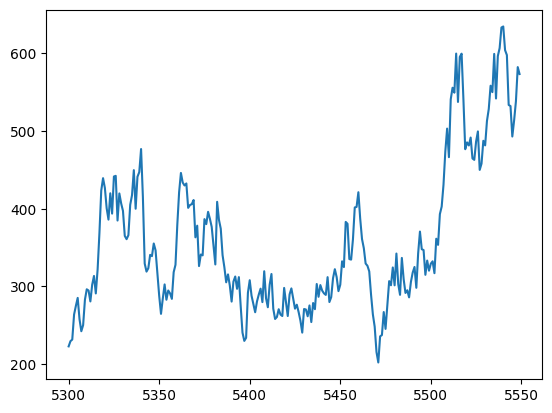

In [341]:
# Sample of prior processes
cov = kernel.forward(X_train[:250]) + gpr.noise.expand(len(X_train[:250])).diag()
y_sample = dist.MultivariateNormal(
    torch.zeros(len(X_train[:250])), covariance_matrix=cov
).sample()
plt.plot(X_train[:250], y_sample.exp())

In [293]:
pyro.clear_param_store()
num_steps = 1000
initial_lr = 0.05
gamma = 0.1  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_steps)
optim = pyro.optim.clipped_adam.ClippedAdam(gpr.parameters(), lr=initial_lr, betas=(0.95, 0.999), lrd=lrd)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optim.step()
    losses.append(loss.item())

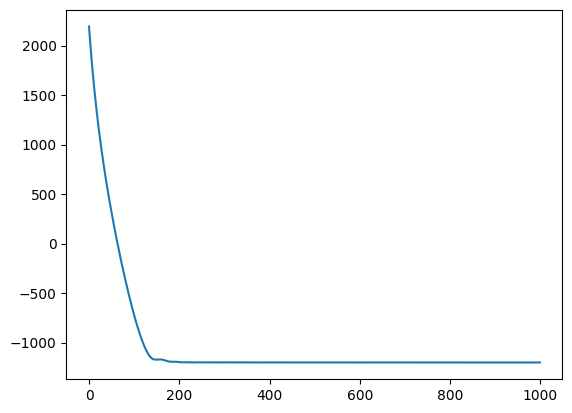

In [294]:
plt.plot(losses)

In [316]:
with torch.no_grad():
    mean, cov = gpr(X_train, full_cov=True, noiseless=False)

sd = cov.diag().sqrt()

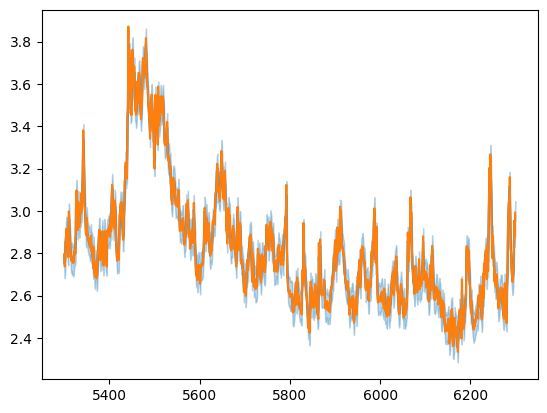

In [322]:
plt.plot(X_train, mean)
plt.fill_between(X_train, mean - 1.95 * sd, mean + 1.95 * sd, color="C0", alpha=0.3)
plt.plot(X_train, y_train)

In [311]:
with torch.no_grad():
    mean, cov = gpr(X_test, full_cov=True, noiseless=False)

sd = cov.diag().sqrt()

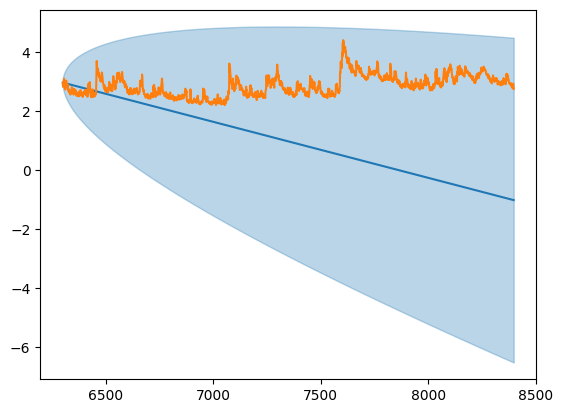

In [312]:
plt.plot(X_test, mean)
plt.fill_between(X_test, mean - 1.95 * sd, mean + 1.95 * sd, color="C0", alpha=0.3)
plt.plot(X_test, y_test)